### Dependencias

In [1]:
from functools import reduce
from itertools import combinations

import cufflinks as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from auxiliares import freq, normalizar
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from varclushi import VarClusHi

cf.go_offline()

### Lectura de Datos

In [2]:
df = pd.read_csv('../Datos/anime_cleaned.csv')
df.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [3]:
# Con display.max_colwidth se puede ver el texto completo de las columnas.
pd.set_option('display.max_colwidth', None)
# Con display.max_columns se puede ver todas las columnas.
pd.set_option('display.max_columns', None)

df.sample()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
2472,19195,Ghost in the Shell: Arise - Border:4 Ghost Stands Alone,Ghost in the Shell: Arise - Border 4: Ghost Stands Alone,攻殻機動隊ARISE -GHOST IN THE SHELL- border:4 Ghost Stands Alone,Koukaku Kidoutai Arise: Ghost in the Shell - Border:4 Ghost Stands Alone,https://myanimelist.cdn-dena.com/images/anime/11/63993.jpg,Movie,Manga,1,Finished Airing,False,"Sep 6, 2014","{'from': '2014-09-06', 'to': '2014-09-06'}",59 min.,R - 17+ (violence & profanity),7.55,11458,1494.0,2292,26121,15,NaN,NaN,NaN,"{'Prequel': [{'mal_id': 19193, 'type': 'anime', 'url': 'https://myanimelist.net/anime/19193/Ghost_in_the_Shell__Arise_-_Border_3_Ghost_Tears', 'title': 'Ghost in the Shell: Arise - Border:3 Ghost Tears'}], 'Other': [{'mal_id': 22013, 'type': 'anime', 'url': 'https://myanimelist.net/anime/22013/Ghost_in_the_Shell__Nyuumon_Arise', 'title': 'Ghost in the Shell: Nyuumon Arise'}], 'Alternative version': [{'mal_id': 29325, 'type': 'anime', 'url': 'https://myanimelist.net/anime/29325/Ghost_in_the_Shell__Arise_-_Alternative_Architecture', 'title': 'Ghost in the Shell: Arise - Alternative Architecture'}]}",Bandai Visual,Funimation,Production I.G,"Mecha, Police, Psychological, Sci-Fi","['""GHOST IN THE SHELL ARISE"" by Cornelius']","['""Split Spirit"" by Yukihiro Takahashi & METAFIVE (Keigo Oyamada x Yoshinori Sunahara x Towa Tei x Tomohiko Kondou x Leo Imai) [高橋幸宏 & METAFIVE（小山田圭吾×砂原良徳×TOWA TEI×ゴンドウトモヒコ×LEO今井）]']",59.0,2014.0


In [4]:
df.shape

(6668, 33)

### Definición de las variables

In [5]:
# Variables continuas
varc = ['episodes','members','score','scored_by','favorites','aired_from_year','duration_min']
# Variables discretas
vard = ['rating','status','type','source','producer','studio','genre']
# Unidad Muestral (Variables que nos interesan)
um = ['anime_id','title','title_english']

In [6]:
# Tomamos las columnas que nos interesan (van a estar ordenadas de acuerdo a como están escritas)
df = df[um + varc + vard]

In [7]:
df.sample(3)

,anime_id,title,title_english,episodes,members,score,scored_by,favorites,aired_from_year,duration_min,rating,status,type,source,producer,studio,genre
2059,4280,Kara no Kyoukai 4: Garan no Dou,the Garden of sinners Chapter 4: The Hollow Shrine,1,128075,8.00,78750,221,2008.0,46.0,R - 17+ (violence & profanity),Finished Airing,Movie,Light novel,Notes,ufotable,"Action, Mystery, Supernatural, Thriller"
2252,30458,"Tokyo Ghoul: ""Jack""",NaN,1,111741,7.62,62949,322,2015.0,30.0,R - 17+ (violence & profanity),Finished Airing,OVA,Manga,NaN,Studio Pierrot,"Action, Drama, Horror, School, Seinen, Supernatural"
133,10521,Working&#039;!!,Wagnaria!!2,13,156252,7.96,93040,386,2011.0,24.0,PG-13 - Teens 13 or older,Finished Airing,TV,4-koma manga,"Aniplex, Yomiuri Telecasting, Rakuonsha",A-1 Pictures,"Slice of Life, Comedy, Romance"


In [8]:
# Ya solo tenemos 17 columnas(las que nos interesan) de las 33 que teníamos.
df.shape

(6668, 17)

In [9]:
x = False
x*1

0

In [10]:
# Creamos una nueva columna (target) que nos arroja 1 (True*1 = 1) si el score es mayor o igual a 8 y
# 0 (False*1 = 0) si es menor a 8.
df['target'] = (df['score']>=8)*1

#df.sample()

In [11]:
# Eliminamos la columna score de las variables continuas
varc.remove('score')
# Eliminamos la variable (columna) score del dataset
df.drop('score', axis=1, inplace=True)

### Partición de Datos

In [12]:
# En este caso indicamos la propoción para validar, en los anteriores indicabamos la propoción a entrenar, 
# pero al final es lo mismo.
train, valid = train_test_split (df, test_size = 0.3)

# Reseteamos los indices
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((4667, 17), (2001, 17))

### Análisis exploratorio de Datos

#### Continuo

##### Ausentes

* La función isnull() nos permite identificar los valores ausentes en el dataset.

In [13]:
# Vemos la proporción de valores ausentes
train[varc].isnull().sum()/len(train)

episodes           0.0
members            0.0
scored_by          0.0
favorites          0.0
aired_from_year    0.0
duration_min       0.0
dtype: float64

##### Varianza de las variables continuas

* La función VarianceThreshold nos permite eliminar aquellas variables que no cumplan con un umbral de varianza.
* Con vt.get_support() podemos ver las variables que cumplen con el umbral de varianza.

In [14]:
vt = VarianceThreshold()
# Ajustamos el modelo
vt.fit(train[varc])

# Obtenemos las variables que tienen varianza mayor a 0
varc = np.array(varc)[vt.get_support()].tolist()
len(varc),varc

(6,
 ['episodes',
  'members',
  'scored_by',
  'favorites',
  'aired_from_year',
  'duration_min'])

##### Multicolinealidad

* La función VarCluHi() nos permite identificar aquellas variables que presentan una alta correlación entre sí.

In [15]:
vc = VarClusHi(df=train,feat_list=varc).varclus()

In [16]:
vc.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,members,0.944531,0.003117,0.055642
1,0,scored_by,0.952281,0.001289,0.047781
2,0,favorites,0.807687,0.000232,0.192357
3,0,episodes,0.017812,0.000782,0.982957
4,1,aired_from_year,0.593736,0.008403,0.409707
5,1,duration_min,0.593736,0.001259,0.406776


* Tanto la función sorted() como sort() ordenan los elementos de una lista, pero la diferencia es que sorted() devuelve una nueva lista ordenada y sort() ordena la lista original.

In [17]:
best = sorted(vc.rsquare.sort_values(by = ['Cluster','RS_Ratio']). # Ordenamos por cluster y por RS_Ratio
groupby('Cluster'). # Agrupamos por cluster
first()['Variable'])# Tomamos el primer registro de cada cluster y nos quedamos con 'Variable'(nom de la variable)
best

['duration_min', 'scored_by']

##### Extremos

array([[<Axes: title={'center': 'duration_min'}>,
        <Axes: title={'center': 'scored_by'}>]], dtype=object)

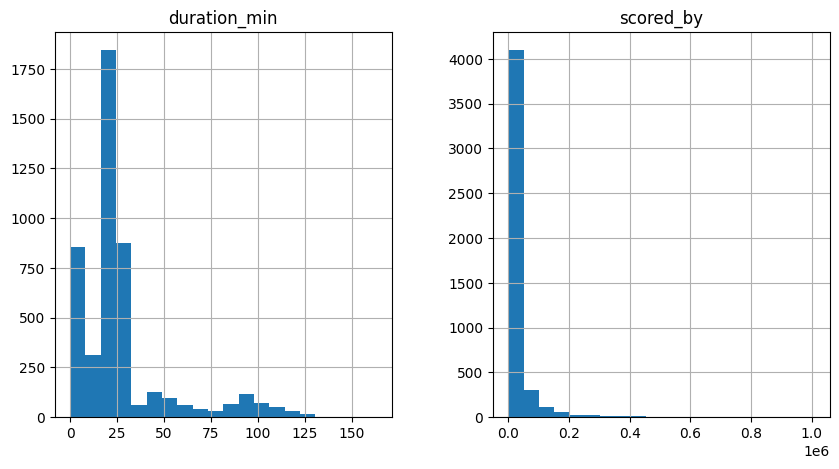

In [18]:
train[best].hist(figsize=(10,5),bins=20)

In [19]:
train[best].describe(percentiles=[0.01,0.99])

,duration_min,scored_by
count,4667.000000,4.667000e+03
mean,28.251903,2.420046e+04
std,25.129485,6.206566e+04
min,0.000000,0.000000e+00
1%,0.500000,8.000000e+00
50%,24.000000,3.938000e+03
99%,117.000000,3.152803e+05
max,163.000000,1.009477e+06


In [20]:
train[best].describe(percentiles=[0.01,0.99]).T

,count,mean,std,min,1%,50%,99%,max
duration_min,4667.0,28.251903,25.129485,0.0,0.5,24.0,117.00,163.0
scored_by,4667.0,24200.461110,62065.657572,0.0,8.0,3938.0,315280.28,1009477.0


In [21]:
train[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']]

,1%,99%
duration_min,0.5,117.00
scored_by,8.0,315280.28


In [22]:
train[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index()

,index,1%,99%
0,duration_min,0.5,117.00
1,scored_by,8.0,315280.28


In [23]:
train[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values

array([['duration_min', 0.5, 117.0],
       ['scored_by', 8.0, 315280.2800000001]], dtype=object)

In [24]:
train[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()

[['duration_min', 0.5, 117.0], ['scored_by', 8.0, 315280.2800000001]]

* Con filter() podemos filtrar los elementos de una lista que cumplan con una condición.
* Con max(axis = 1) podemos obtener el valor máximo de cada fila de una matriz.
* Con value_counts() podemos obtener la frecuencia de cada valor de una variable.

In [25]:
for v,li,ls in train[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    # Creamos una nueva columna que nos arroja 1 si el valor de la variable es menor al 1% o mayor al 99%
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)

# Cramos una nueva columna con el valor maximo de las variables ex_ de cada registro.    
train['ex_'] = train.filter(like='ex_').max(axis=1)
train.sample(2)

,anime_id,title,title_english,episodes,members,scored_by,favorites,aired_from_year,duration_min,rating,status,type,source,producer,studio,genre,target,ex_duration_min,ex_scored_by,ex_
3015,2571,Mitsubachi Maya no Bouken,Maya the Bee,52,5380,3080,11,1975.0,25.0,G - All Ages,Finished Airing,TV,Book,NaN,Nippon Animation,"Adventure, Comedy, Kids",0,0,0,0
1041,8829,Shounen Ashibe (TV),NaN,37,311,46,1,1991.0,25.0,G - All Ages,Finished Airing,TV,4-koma manga,TBS,Life Work,"Comedy, Slice of Life",0,0,0,0


In [26]:
# Obtenemos la frecuencia de 1's y 0's de la variable (columna) ex_
train['ex_'].value_counts(1)

0    0.962931
1    0.037069
Name: ex_, dtype: float64

In [27]:
# Eliminamos los registros que tienen 1 en la variable ex_
train = train[train['ex_']==0].reset_index(drop=True)
# Eliminamos las variables ex_ del dataset
train = train.drop(train.filter(like='ex_').columns,axis=1)

array([[<Axes: title={'center': 'duration_min'}>,
        <Axes: title={'center': 'scored_by'}>]], dtype=object)

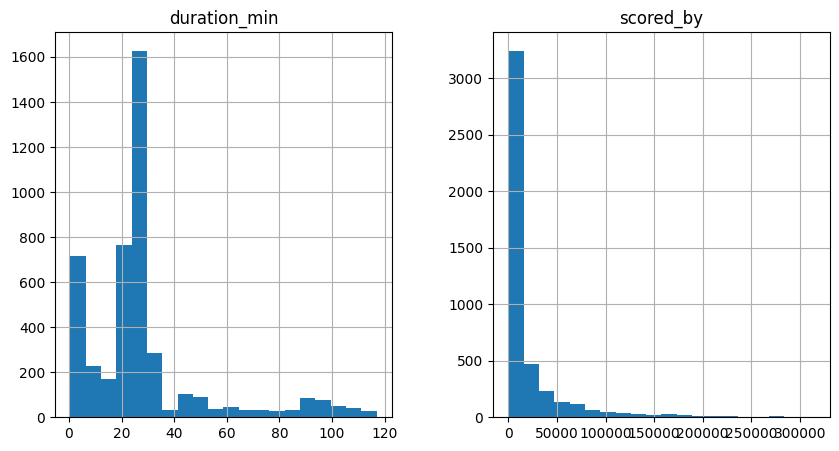

In [28]:
train[best].hist(figsize=(10,5),bins=20)

#### Discreto

##### Normalización

In [29]:
for v in vard:
    # Rellenamos los valores ausentes con 'Missing'
    train[v].fillna('Missing',inplace=True)

* La función freq() nos permite obtener la frecuencia de cada valor de una variable.

In [30]:
freq(train,vard)

****Tabla de frecuencias  rating  ***


                                  FA        FR   FAA       FRA
G - All Ages                     656  0.145972   656  0.145972
None                              47  0.010458   703  0.156431
PG - Children                    320  0.071206  1023  0.227637
PG-13 - Teens 13 or older       2319  0.516021  3342  0.743658
R - 17+ (violence & profanity)   512  0.113930  3854  0.857588
R+ - Mild Nudity                 399  0.088785  4253  0.946373
Rx - Hentai                      241  0.053627  4494  1.000000




****Tabla de frecuencias  status  ***


                    FA        FR   FAA       FRA
Currently Airing   117  0.026035   117  0.026035
Finished Airing   4377  0.973965  4494  1.000000




****Tabla de frecuencias  type  ***


           FA        FR   FAA       FRA
Movie     550  0.122385   550  0.122385
Music      67  0.014909   617  0.137294
ONA       265  0.058968   882  0.196262
OVA       943  0.209835  1825  0.406097
Special   680  0.151313

* La función normalizar() nos permite normalizar los valores de una variable.

In [31]:
# Creamos una lista con los valores de las variables discretas normalizados
mapa_norm = list(map(lambda v:normalizar(train,v),vard))

# Creamos una nueva columna para cada variable discreta normalizada
for v, mapa in mapa_norm:
    train[f'n_{v}'] = train[v].replace(mapa)

# Creamos una lista con el nombre de las variables discretas normalizadas.    
varn = [f'n_{v}' for v in vard]

freq(train,varn)

****Tabla de frecuencias  n_rating  ***


                                  FA        FR   FAA       FRA
G - All Ages                     656  0.145972   656  0.145972
PG - Children                    320  0.071206   976  0.217178
PG-13 - Teens 13 or older       2366  0.526480  3342  0.743658
R - 17+ (violence & profanity)   512  0.113930  3854  0.857588
R+ - Mild Nudity                 399  0.088785  4253  0.946373
Rx - Hentai                      241  0.053627  4494  1.000000




****Tabla de frecuencias  n_status  ***


                   FA   FR   FAA  FRA
Finished Airing  4494  1.0  4494  1.0




****Tabla de frecuencias  n_type  ***


           FA        FR   FAA       FRA
Movie     550  0.122385   550  0.122385
ONA       265  0.058968   815  0.181353
OVA       943  0.209835  1758  0.391188
Special   680  0.151313  2438  0.542501
TV       2056  0.457499  4494  1.000000




****Tabla de frecuencias  n_source  ***


                FA        FR   FAA       FRA
Game           293  

##### Varianza cero (Unitarias)

In [32]:
# Lista con las variables discretas que solo tienen un valor.
unarias = [v for v in varn if len(train[v].unique())==1]

# Eliminamos las variables discretas que solo tienen un valor, es decir, nos quedamos con las que 
# no están en la lista unarias.
varn = [v for v in varn if v not in unarias]

len(varn)

5

### Espacios

#### Natural $\mathcal{X}$

* La función OneHotEncoder() nos permite codificar las variables categóricas en variables binarias (0,1).

In [33]:
# Creamos un nuevo dataset con las variables continuas que elegimos con el cluster 
# (best = ['duration_min','scored_by'])
X = train[best].copy() 

oh = OneHotEncoder(sparse=True, handle_unknown='ignore', drop='if_binary') 
# Entrenamos el objeto con las variables discretas normalizadas del dataset de train
oh.fit(train[varn])

# Concatenamos las variables discretas normalizadas codificadas al dataset de variables continuas.
X = pd.concat([X, pd.DataFrame(oh.transform(train[varn]).toarray(), 
              columns=oh.get_feature_names_out())], axis=1) 
X.head() 

/home/guadalupe/analisis/EV/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,duration_min,scored_by,n_rating_G - All Ages,n_rating_PG - Children,n_rating_PG-13 - Teens 13 or older,n_rating_R - 17+ (violence & profanity),n_rating_R+ - Mild Nudity,n_rating_Rx - Hentai,n_type_Movie,n_type_ONA,n_type_OVA,n_type_Special,n_type_TV,n_source_Game,n_source_Light novel,n_source_Manga,n_source_Original,n_source_Otros,n_source_Visual novel,n_producer_Otros,n_studio_Toei Animation
0,2.0,436,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25.0,22411,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,23.0,18389,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,29.0,16292,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,25.0,70,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


##### Espacio de híper-caja $\mathcal{X}_{[0,1]}$

In [34]:
# Transformamos las variables continuas a valores entre 0 y 1
sc01 = MinMaxScaler()

# Entrenamos el objeto
sc01.fit(X)
X01 = pd.DataFrame(sc01.transform(X),columns=X.columns)
X01.head()

,duration_min,scored_by,n_rating_G - All Ages,n_rating_PG - Children,n_rating_PG-13 - Teens 13 or older,n_rating_R - 17+ (violence & profanity),n_rating_R+ - Mild Nudity,n_rating_Rx - Hentai,n_type_Movie,n_type_ONA,n_type_OVA,n_type_Special,n_type_TV,n_source_Game,n_source_Light novel,n_source_Manga,n_source_Original,n_source_Otros,n_source_Visual novel,n_producer_Otros,n_studio_Toei Animation
0,0.012876,0.001358,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.210300,0.071093,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.193133,0.058330,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.244635,0.051675,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.210300,0.000197,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


##### Espacio de componentes principales $\mathcal{X}_{p}$

** Recordemos que para usar PCA las variables deben estar normalizadas, por eso usamos StandarScaler(). **
* Con .explained_variance_ratio_ podemos obtener la varianza explicada por cada componente principal.

In [35]:
# En este caso dentro de PCA indicamos la cantidad de información con la que nos queremos quedar 
# y no la cantidad de componentes a usar (15)
pipe = make_pipeline(StandardScaler(),PCA(n_components=0.95),MinMaxScaler())
pipe.fit(X)
Xp = pd.DataFrame(pipe.transform(X))

print(pipe.steps[1][1].explained_variance_ratio_.cumsum())
Xp.head()

[0.10804666 0.20710073 0.30065483 0.37989699 0.44670705 0.5107532
 0.57414903 0.63333737 0.68699496 0.73882861 0.78480406 0.82708487
 0.86689096 0.90317029 0.93647113 0.96657236]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.412379,0.779956,0.161900,0.467428,0.441640,0.778524,0.962224,0.309236,0.469119,0.630339,0.400834,0.369198,0.485873,0.469865,0.431027,0.423150
1,0.191291,0.292437,0.286482,0.473370,0.693841,0.579748,0.262738,0.489300,0.537926,0.539513,0.675702,0.432768,0.295815,0.266895,0.284927,0.147232
2,0.256422,0.551288,0.206482,0.534093,0.654924,0.321032,0.259506,0.232229,0.513598,0.505137,0.401619,0.460785,0.352315,0.480560,0.680772,0.272118
3,0.557072,0.435465,0.275438,0.299329,0.361680,0.469341,0.187711,0.243025,0.982185,0.389645,0.291309,0.506044,0.374939,0.626441,0.405830,0.386733
4,0.414251,0.676029,0.653165,0.778274,0.439608,0.172236,0.369349,0.405913,0.387598,0.618174,0.771471,0.607512,0.434497,0.643252,0.396645,0.274704


* Con round() podemos redondear los valores de una lista.

In [36]:
# Vemos la correlación entre las variables
Xp.corr().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0
1,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
3,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
4,-0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
5,0.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
6,0.0,0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0
7,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
8,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
9,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0


### Aprendizaje

#### Entrenamiento con Híperparametrización

* La función RandomizedSearchCV() nos permite realizar una búsqueda aleatoria de los mejores hiperparámetros para un modelo.

In [37]:
# Usamos la maquina vector soporte
mod = SVC()

# Creamos un diccionario con los hiperparametros que queremos probar en el modelo.
hp = {'C': np.arange(0.1, 2, 0.1), 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [
    'scale', 'auto'], 'probability': [True],'degree':[2,3,4,5]}

# Número de combinaciones de hiperparametros    
print(reduce(lambda x,y: x*y,[len(hp[k]) for k in hp.keys()]))


grid = RandomizedSearchCV(mod, hp, cv=5, n_iter=20, n_jobs=-1, verbose=1,scoring='roc_auc')

# Entrenamos el modelos con nuestras X's (Xp) y nuestra Y ('target')
grid.fit(Xp, train['target'])

# Imprimimos los mejores hiperparametros y el score
print(grid.best_params_,grid.best_score_)

# Obtenemos el modelo con los mejores hiperparametros
mod = grid.best_estimator_
# Entrenamos el modelo con las X's y la Y
mod.fit(Xp, train['target'])

456
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'probability': True, 'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'C': 0.6} 0.8267146444028132


SVC(C=0.6, degree=2, kernel='poly', probability=True)

In [38]:
# Obtenemos el score del modelo
roc_auc_score(train['target'],mod.predict_proba(Xp)[:,1])

0.8609998331440347

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

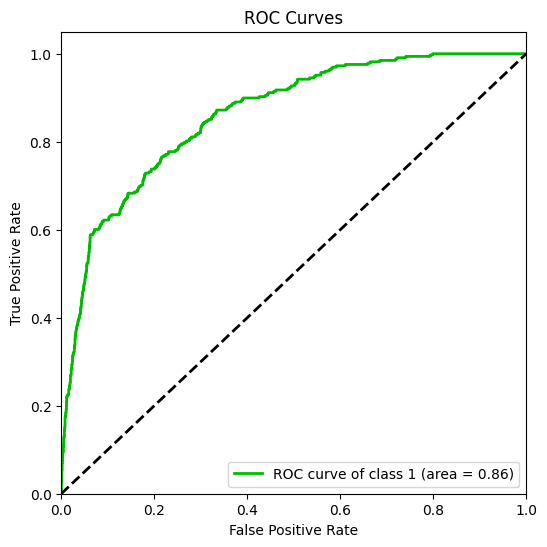

In [39]:
plot_roc(train['target'], mod.predict_proba(Xp), plot_macro=False,
         plot_micro=False, figsize=(6, 6), classes_to_plot=[1])     

### Validación del modelo

##### Hacemos lo mismo que arriba pero ahora con los datos de validación

In [40]:
for v, mapa in mapa_norm:
    # Creamos una nueva variable que es el valor de la variable discreta normalizada
    valid[f'n_{v}'] = valid[v].replace(mapa) 

In [41]:
Xv = valid[best].copy() 
Xv = pd.concat([Xv, pd.DataFrame(oh.transform(valid[varn]).toarray(),
              columns=oh.get_feature_names_out())], axis=1) 
Xv.head()

/home/guadalupe/analisis/EV/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros



,duration_min,scored_by,n_rating_G - All Ages,n_rating_PG - Children,n_rating_PG-13 - Teens 13 or older,n_rating_R - 17+ (violence & profanity),n_rating_R+ - Mild Nudity,n_rating_Rx - Hentai,n_type_Movie,n_type_ONA,n_type_OVA,n_type_Special,n_type_TV,n_source_Game,n_source_Light novel,n_source_Manga,n_source_Original,n_source_Otros,n_source_Visual novel,n_producer_Otros,n_studio_Toei Animation
0,25.0,11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,28722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,39.0,77,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,24.0,2945,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,23.0,14254,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Aplicamos la transformación
Xvp = pd.DataFrame(pipe.transform(Xv)) 
Xvp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.307331,0.689103,0.195947,0.240318,0.532023,0.393399,0.563334,0.111654,0.557717,0.577677,0.377713,0.636098,0.534059,0.214423,0.654079,0.268963
1,0.517438,0.533308,0.036844,0.623912,0.706986,0.402275,0.308237,0.592968,0.300086,0.220399,0.765774,0.413279,0.860088,0.667242,0.636425,0.185598
2,0.424092,0.681046,0.696753,0.769773,0.456906,0.170325,0.364188,0.411429,0.392049,0.617033,0.762139,0.602144,0.435366,0.644203,0.395943,0.270424
3,0.284235,0.509041,0.274211,0.342751,0.225078,0.145235,0.322076,0.508083,0.478094,0.545468,0.486246,0.223536,0.406346,0.284845,0.324800,0.281253
4,0.525361,0.416655,0.330297,0.762746,0.398778,0.324380,0.386939,0.455197,0.483836,0.386579,0.426758,0.472963,0.255255,0.360550,0.593380,0.370812


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

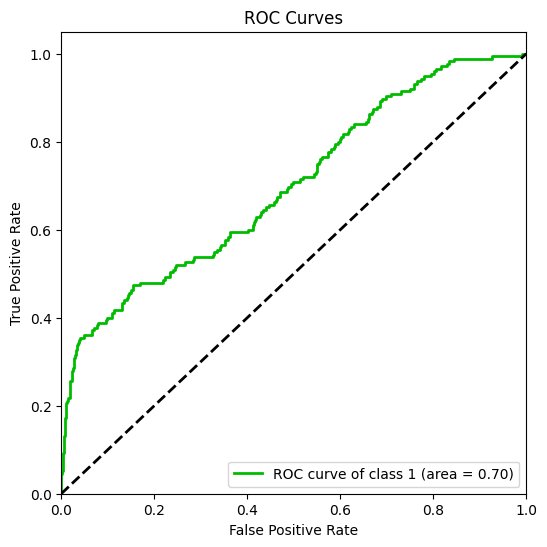

In [43]:
plot_roc(valid['target'], mod.predict_proba(Xvp), plot_macro=False,
         plot_micro=False, figsize=(6, 6), classes_to_plot=[1])    

(array([1960.,   14.,   10.,    4.,   13.]),
 array([7.42941246e-04, 2.00594353e-01, 4.00445765e-01, 6.00297176e-01,
        8.00148588e-01, 1.00000000e+00]),
 <BarContainer object of 5 artists>)

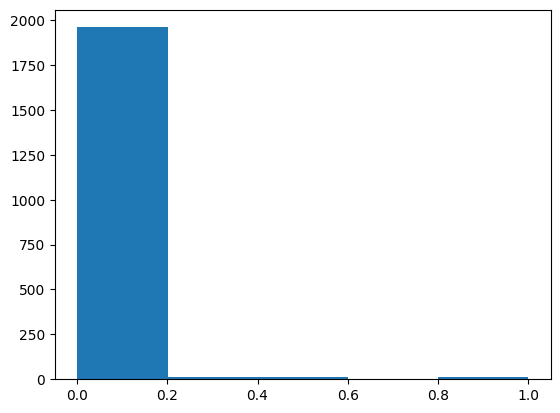

In [44]:
# Vemos la distribución de las probabilidades predichas por el modelo de clasificación 
plt.hist(mod.predict_proba(Xvp)[:,1],bins=5) 

### Reporte del modelo

* La función pd.cut() nos permite crear intervalos de una variable continua.

In [45]:
# Creamos una nueva variable(Columna) que es el valor de la variable discreta normalizado, 
# para el dataset de entrenamiento y para el de validación
train['r_proba'] = pd.cut(mod.predict_proba(Xp)[:,1],bins=np.arange(0,1.2,0.2)).astype(str)
valid['r_proba'] = pd.cut(mod.predict_proba(Xvp)[:,1],bins=np.arange(0,1.2,0.2)).astype(str) 

* Con assign() podemos crear nuevas variables en un dataframe. Dentro del paréntesis se especifica el nombre de la nueva variable y el valor que tomará.

In [46]:
# concatenamos los datasets de train y valid tomando las variables 'r_proba' y 'target' y 
# asignamos el valor 'train' a la variable 'muestra' y el valor 1 a la variable 'n'
aux = pd.concat([train[['r_proba','target']].assign(muestra='train').assign(n=1),
valid[['r_proba','target']].assign(muestra='valid').assign(n=1)],ignore_index=True)


* La función to_cipboard() nos permite copiar el contenido de un dataframe al portapapeles. Con index = False evitamos que se copie el índice.

In [48]:
# Vemos la distribución de las probabilidades predichas por el modelo de clasificación con los mejores 
# hiperparámetros
aux.groupby(['r_proba','muestra','target']).agg({'n':'count'}).reset_index().to_clipboard(index=False) 

QSocketNotifier: Can only be used with threads started with QThread


### Ejemplos

In [51]:
# Vemos las películas que el modelo de clasificación con los mejores hiperparámetros predice que tienen más 
# de un 80% de probabilidades de ser de acción
valid[valid['r_proba']=='(0.8, 1.0]'].sort_values(by='title_english')['title_english'].to_clipboard(index=False)


In [50]:
# Vemos las películas que el modelo de clasificación con los mejores hiperparámetros predice 
# que tienen entre un 60% y un 80% de probabilidades de ser de acción
valid[valid['r_proba']=='(0.6, 0.8]'].sort_values(by='title_english')


,anime_id,title,title_english,episodes,members,scored_by,favorites,aired_from_year,duration_min,rating,status,type,source,producer,studio,genre,target,n_rating,n_status,n_type,n_source,n_producer,n_studio,n_genre,r_proba
459,6922,Fate/stay night Movie: Unlimited Blade Works,Fate/stay night: Unlimited Blade Works,1,136486,77292,732,2010.0,100.0,PG-13 - Teens 13 or older,Finished Airing,Movie,Visual novel,"Geneon Universal Entertainment, Frontier Works, TBS, KlockWorx, Notes, CREi",Studio Deen,"Action, Fantasy, Magic, Supernatural",0,PG-13 - Teens 13 or older,Finished Airing,Movie,Visual novel,"Geneon Universal Entertainment, Frontier Works, TBS, KlockWorx, Notes, CREi",Otros,"Action, Fantasy, Magic, Supernatural","(0.6, 0.8]"
818,437,Perfect Blue,Perfect Blue,1,180949,94645,3580,1998.0,80.0,R+ - Mild Nudity,Finished Airing,Movie,Novel,NaN,Madhouse,"Dementia, Horror, Psychological, Drama",1,R+ - Mild Nudity,Finished Airing,Movie,Otros,NaN,Otros,"Dementia, Horror, Psychological, Drama","(0.6, 0.8]"
408,6675,Redline,Redline,1,157591,90299,2411,2009.0,102.0,R+ - Mild Nudity,Finished Airing,Movie,Original,Tohokushinsha Film Corporation,Madhouse,"Action, Sci-Fi, Cars, Sports",1,R+ - Mild Nudity,Finished Airing,Movie,Original,Otros,Otros,"Action, Sci-Fi, Cars, Sports","(0.6, 0.8]"
858,21557,Omoide no Marnie,When Marnie Was There,1,95955,48625,910,2014.0,103.0,G - All Ages,Finished Airing,Movie,Novel,"Dentsu, Toho, Walt Disney Studios, Nippon Television Network",Studio Ghibli,"Mystery, Psychological, Drama",1,G - All Ages,Finished Airing,Movie,Otros,"Dentsu, Toho, Walt Disney Studios, Nippon Television Network",Otros,"Mystery, Psychological, Drama","(0.6, 0.8]"
